In [1]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, relu=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if relu:
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv3 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, relu=False)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, stride=1, bias=False, relu=False)        
        self.i_downsample = i_downsample
        self.relu = nn.ReLU()
    
    def forward(self, x):
      
        out = self.conv1(x)
        out = self.conv2(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class ResNet(nn.Module):
    def __init__(self, ResBlock, in_channels, layer_list, planes, num_classes, num_channels=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.conv1 = ConvBlock(num_channels, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
#         print(self.conv1)
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        layers = [self._make_layer(ResBlock, layer_list[0], planes[0])]
        for i in range(1, len(layer_list)):
            layers.append(self._make_layer(ResBlock, layer_list[i], planes[i], stride=2))
        self.layers = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(planes[-1]*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.max_pooling(out)
        out = self.layers(out)
        out = out.reshape(out.shape[0], -1)
#         print(out.shape[0])
        out = self.fc(out)
        return out
    
    def _make_layer(self, ResBlock, num_blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = ConvBlock(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride, relu=False)
            
        layers.append(ResBlock(self.in_channels, planes, ii_downsample, stride))
        self.in_channels = planes * ResBlock.expansion
        for i in range(num_blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)
    
def ResNet18(num_classes, channels=3):
    return ResNet(Block, 64, [2, 2, 2, 2], [64, 128, 256, 512], num_classes, channels, 1)

def ResNet34(num_classes, channels=3):
    return ResNet(Block, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 1)
    
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 23, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 8, 36, 3], [64, 128, 256, 512], num_classes, channels, 2)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:02<00:00, 78538134.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet50(10).to(device)
model.load_state_dict(torch.load("/kaggle/input/resnet-result/resnet50_cifar10_10.pt", weights_only=True))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score


def evaluate(model, plot=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    print("Accuracy: ", accuracy)
    print("F1 score: ", f1_macro)
    if plot:
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

epochs = 100
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            


Loss [9](epoch):  0.7218281130504121
Accuracy:  0.7559
F1 score:  0.7540523509453512
Loss [19](epoch):  0.6472066073771328
Accuracy:  0.7717
F1 score:  0.7706611862662333
Loss [29](epoch):  0.6154372921532683
Accuracy:  0.777
F1 score:  0.776362672056839
Loss [39](epoch):  0.6011490766959422
Accuracy:  0.7821
F1 score:  0.7807713916812833
Loss [49](epoch):  0.5815928402306784
Accuracy:  0.7835
F1 score:  0.7826771654243684
Loss [59](epoch):  0.563368773826248
Accuracy:  0.7828
F1 score:  0.7816676607039877
Loss [69](epoch):  0.5392673698532612
Accuracy:  0.7836
F1 score:  0.7834337035725862
Loss [79](epoch):  0.5215440562466527
Accuracy:  0.7942
F1 score:  0.7924581060378935
Loss [89](epoch):  0.5040184900431377
Accuracy:  0.7925
F1 score:  0.7918864623567812
Loss [99](epoch):  0.4884215340285045
Accuracy:  0.7917
F1 score:  0.7897802007681902


Accuracy:  0.7917
F1 score:  0.7897802007681902


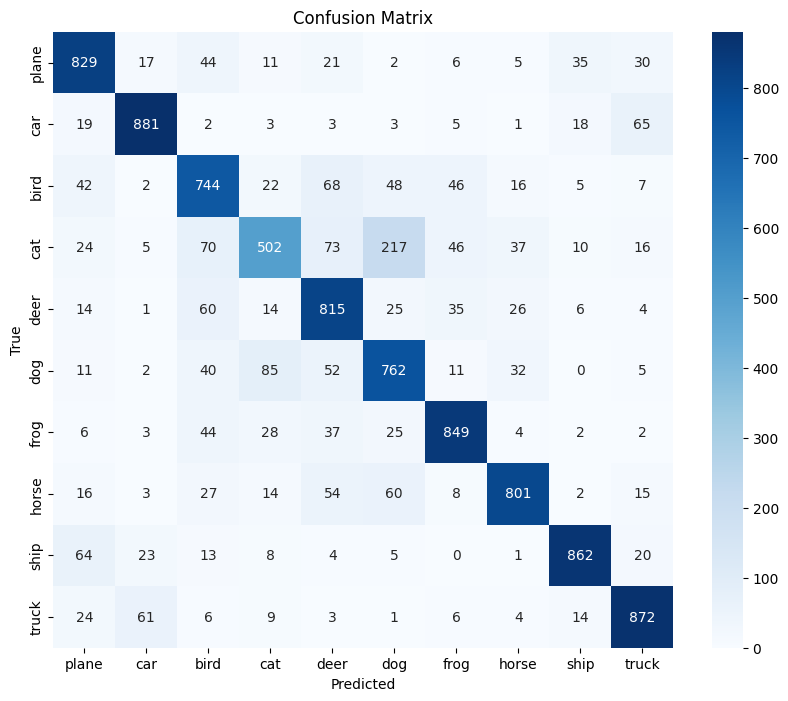

In [8]:
evaluate(model, plot=True)

In [9]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.4790009224353849
Accuracy:  0.7947
F1 score:  0.7943600705216266
Loss [9](epoch):  0.4739504887929658
Accuracy:  0.7967
F1 score:  0.794267827813609
Loss [14](epoch):  0.4663033699211867
Accuracy:  0.796
F1 score:  0.7942217029421786
Loss [19](epoch):  0.45532336236570803
Accuracy:  0.7937
F1 score:  0.7933057733005525
Loss [24](epoch):  0.4505565022416127
Accuracy:  0.801
F1 score:  0.8003979736526375
Loss [29](epoch):  0.4456152512746699
Accuracy:  0.7966
F1 score:  0.7965538606925172
Loss [34](epoch):  0.4338099701935068
Accuracy:  0.794
F1 score:  0.7926935649399793
Loss [39](epoch):  0.42521625509499894
Accuracy:  0.7991
F1 score:  0.7976980915112107
Loss [44](epoch):  0.4174597516389149
Accuracy:  0.7958
F1 score:  0.7937425966842775
Loss [49](epoch):  0.41127156933097886
Accuracy:  0.8022
F1 score:  0.8020459748522691


In [10]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.40197999089422737
Accuracy:  0.7976
F1 score:  0.7974770967659094
Loss [9](epoch):  0.39489929953499525
Accuracy:  0.8024
F1 score:  0.8007609130466647
Loss [14](epoch):  0.38820451193148525
Accuracy:  0.8023
F1 score:  0.8027043092174047
Loss [19](epoch):  0.3799050199177564
Accuracy:  0.7975
F1 score:  0.7971165904322658
Loss [24](epoch):  0.3675435214015224
Accuracy:  0.7974
F1 score:  0.7950284186611075
Loss [29](epoch):  0.3666408328372804
Accuracy:  0.8004
F1 score:  0.7988371959562655
Loss [34](epoch):  0.35702302346906395
Accuracy:  0.8017
F1 score:  0.8015421641449979
Loss [39](epoch):  0.3524911898328825
Accuracy:  0.7903
F1 score:  0.7914509006419628
Loss [44](epoch):  0.3413136280939707
Accuracy:  0.7994
F1 score:  0.7989538653077689
Loss [49](epoch):  0.3354683970017811
Accuracy:  0.7961
F1 score:  0.7965582695091433


Accuracy:  0.7961
F1 score:  0.7965582695091433


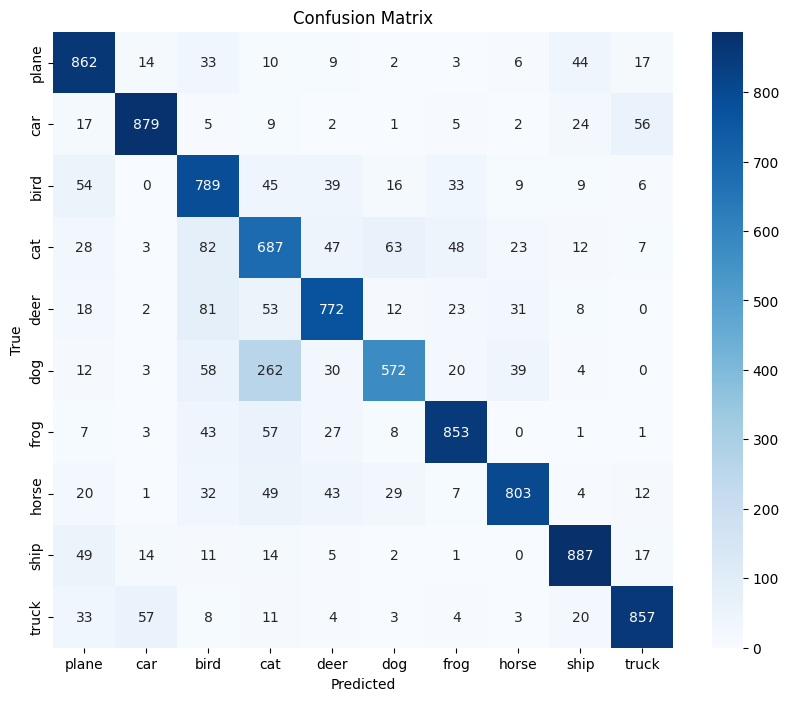

In [11]:
evaluate(model, plot=True)